# Import necessary libraries


In [1]:
import os
import cv2
import time
import numpy as np
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Attention, Lambda
)

# Initialize MediaPipe holistic model and drawing utilities

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model -  used for tracking and detecting multiple body parts simultaneously
mp_drawing = mp.solutions.drawing_utils # Drawing utilities - used for visualizing the detected landmarks on images or video frames

# Section 1: Utility Functions
-----------------------------------------------------------------------------------

In [3]:
def mediapipe_detection(image, model):
    """
    Performs MediaPipe detection on an input image.
    
    Parameters:
        image (ndarray): The input image for processing.
        model (object): MediaPipe holistic model.
        
    Returns:
        tuple: Processed image and holistic model predictions.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB - Why? -> OpenCV captures images in the BGR color format, while MediaPipe requires the RGB color format for processing
    image.flags.writeable = False                  # MAKE IMAGE NOT WRITABLE - Why? -> 1. optimizes processing by reducing memory operations 2. MediaPipe doesn’t need to modify the image during detection, so this prevents accidental changes
    results = model.process(image)                 # PREDICTION - detecting landmarks for the face, pose, and hands
    image.flags.writeable = True                   # MAKE IMAGE WRITABLE 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    """
    Draws styled landmarks on the input image for face, pose, and hands using MediaPipe.
    
    Parameters:
        image (ndarray): The image on which landmarks will be drawn.
        results (object): MediaPipe holistic model predictions.
    """
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def extract_keypoints(results):
    """
    Extracts keypoints from MediaPipe holistic model predictions for pose, face, left hand, and right hand.
    
    Parameters:
        results (object): MediaPipe holistic model predictions.
        
    Returns:
        ndarray: A concatenated array of keypoints for pose (33x4), face (468x3), left hand (21x3), 
                 and right hand (21x3). Missing landmarks are replaced with zeros.
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

# Section 2: Variable Definition
-----------------------------------------------------------------------------------

In [6]:
DATA_PATH = os.path.join('MP_Data') 

actions = np.array(['hello', 'yes', 'no', 'thank-you'])

# Videos in 30 frames in length
sequence_length = 30

#Number of features extracted per frame (pose, face, and hand keypoints)
num_features = 1662

# Section 2: Preprocess Data and Create Labels and Features
-----------------------------------------------------------------------------------

In [7]:
label_map = {label:num for num, label in enumerate(actions)}

In [8]:
label_map

{'hello': 0, 'yes': 1, 'no': 2, 'thank-you': 3}

In [9]:
# Initialize empty lists to store the data and corresponding labels
data = []  # Will hold the sequences of extracted keypoints
labels = []  # Will hold the corresponding gesture labels

In [10]:
# --------------------- Load Data and Labels ---------------------

# Loop through each gesture (action) and its assigned label index
for label_name, label_idx in label_map.items():
    # Define the path to the folder containing sequences for the current gesture
    sign_path = os.path.join(DATA_PATH, label_name)

    # Loop through each sequence folder for the current gesture
    for sample_folder in os.listdir(sign_path):
        # Define the path to the specific sequence folder
        sample_path = os.path.join(sign_path, sample_folder)
        
        # Load all .npy files in the folder (representing individual frames)
        frames = [np.load(os.path.join(sample_path, frame)) 
                  for frame in sorted(os.listdir(sample_path)) if frame.endswith('.npy')]
        
        # Verify that the sequence contains the expected number of frames
        if len(frames) != sequence_length:
            print(f"Warning: {sample_path} contains {len(frames)} frames instead of {sequence_length}")
            continue  # Skip this sample if the sequence length is incorrect
        
        # Stack all frame keypoints for this sequence into a single array
        data.append(np.stack(frames))  # Shape: (sequence_length, num_features)

        # Append the corresponding label for this gesture
        labels.append(label_idx)

# Convert the data and labels lists to NumPy arrays for model training
data = np.array(data)  # Shape: (num_samples, sequence_length, num_features)
labels = np.array(labels)  # Shape: (num_samples,)

In [11]:
# --------------------- Split Data into Train, Validation, and Test Sets ---------------------

# Split the data into training and temporary sets (30% reserved for validation and testing)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the temporary set equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [12]:
# --------------------- One-Hot Encode Labels ---------------------

# Convert the integer labels into one-hot encoded format for categorical classification
y_train = to_categorical(y_train, num_classes=len(label_map))
y_val = to_categorical(y_val, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

In [13]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (294, 30, 1662), y_train shape: (294, 4)
X_val shape: (63, 30, 1662), y_val shape: (63, 4)
X_test shape: (63, 30, 1662), y_test shape: (63, 4)


# Section 3: Model Training
-----------------------------------------------------------------------------------

In [14]:
def build_model():
    """
    Builds a deep learning model for sequence-based classification tasks.

    Model Architecture:
    - Input Layer: Accepts sequences with shape (30, 1662).
    - Conv1D Layer: Extracts spatial features from sequences.
    - MaxPooling1D: Reduces dimensionality while preserving significant features.
    - Bidirectional LSTM: Captures temporal dependencies in both forward and backward directions.
    - Attention Mechanism: Focuses on relevant parts of the sequence.
    - Dense Layers: Performs classification using extracted features.
    - Output Layer: Predicts class probabilities for 4 output classes.
    
    Returns:
        A compiled Keras model.
    """
    # Input Layer: Specifies the input shape as sequences with 30 frames and 1662 features per frame
    input_layer = Input(shape=(30, 1662))  # Shape: (sequence_length, num_features)

    # Convolutional Layer: 
    # Extracts local spatial features from the input sequence. 
    # The kernel size of 3 defines the size of the sliding window used for convolution.
    conv_out = Conv1D(64, kernel_size=3, activation='relu')(input_layer)

    # MaxPooling Layer: 
    # Reduces the spatial dimensions by taking the maximum value within a pooling window. 
    # This helps reduce computational complexity and improves feature selection.
    conv_out = MaxPooling1D(pool_size=2)(conv_out)

    # Bidirectional LSTM Layer: 
    # Processes the sequence in both forward and backward directions to capture temporal dependencies. 
    # Outputs a sequence of features with 128 units in each direction (total 256).
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, activation='relu'))(conv_out)

    # Dropout Layer: 
    # Randomly drops a fraction (30%) of the LSTM units during training to prevent overfitting.
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention Layer: 
    # Focuses on the most important parts of the sequence for the classification task.
    # Attention is applied to the LSTM outputs to weigh features based on relevance.
    attention_out = Attention()([lstm_out, lstm_out])

    # Lambda Layer: 
    # Reduces the attention output to a fixed-size vector by summing along the sequence dimension. 
    # This ensures compatibility with the subsequent dense layers.
    attention_out = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_out)

    # Dense Layer: 
    # Fully connected layer with 128 neurons to learn complex patterns from the attention output.
    # Includes L2 regularization to penalize large weights and prevent overfitting.
    dense_out = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(attention_out)

    # Dropout Layer: 
    # Randomly drops a fraction (30%) of the dense layer neurons during training for regularization.
    dense_out = Dropout(0.3)(dense_out)

    # Output Layer: 
    # Fully connected layer with 4 neurons (one for each class) and a softmax activation function.
    # Softmax converts the outputs into probabilities summing to 1 across the classes.
    output_layer = Dense(4, activation='softmax')(dense_out)

    # Compile the model:
    # - Optimizer: Adam with a learning rate of 0.0001 for adaptive learning.
    # - Loss Function: Categorical Crossentropy to compare predicted and true probability distributions.
    # - Metric: Accuracy to evaluate the model's performance during training and testing.
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [32]:
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 30, 1662)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 28, 64)            │         319,168 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 14, 64)            │               0 │ conv1d_2[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 14, 256)           │         197,632 │ max_pooling1d_2[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 14, 256)           │               0 │ bidirectional_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_2 (Attention)       │ (None, 14, 256)           │               0 │ dropout_4[0][0],           │
│                               │                           │                 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_2 (Lambda)             │ (None, 256)               │               0 │ attention_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          32,896 │ lambda_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 4)                 │             516 │ dropout_5[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 550,212 (2.10 MB)

 Trainable params: 550,212 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
"""
Early stopping is a regularization technique used to prevent overfitting during training. 
- If the validation accuracy does not improve for 10 consecutive epochs (patience=10), the training stops.
- The weights of the best-performing epoch are restored to ensure the final model reflects its optimal state.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',      
    patience=10,                  
    restore_best_weights=True,    
    mode='max',                   
    verbose=1                     
)

In [17]:
"""
ModelCheckpoint saves the model whenever the validation accuracy improves.
- This ensures that the best model is preserved even if subsequent epochs result in overfitting.
- The saved model can later be loaded for evaluation or inference.
"""
model_checkpoint = ModelCheckpoint(
    filepath='best_model6.keras',  
    monitor='val_accuracy',                 
    save_best_only=True,                    
    mode='max',                            
    verbose=1                               
)

In [33]:
# The `model.fit` function initiates the training process.
history = model.fit(
    X_train, y_train,                       
    validation_data=(X_val, y_val),         
    epochs=500,                            
    batch_size=8,                          
    callbacks=[early_stopping, model_checkpoint],  
    verbose=1                               
)

Epoch 1/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2943 - loss: 1.7837
Epoch 1: val_accuracy did not improve from 0.87302
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.3008 - loss: 1.7548 - val_accuracy: 0.5079 - val_loss: 0.9258
Epoch 2/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5110 - loss: 0.9943
Epoch 2: val_accuracy did not improve from 0.87302
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5106 - loss: 0.9939 - val_accuracy: 0.6667 - val_loss: 0.7939
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5071 - loss: 0.9752
Epoch 3: val_accuracy did not improve from 0.87302
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5079 - loss: 0.9737 - val_accuracy: 0.4921 - val_loss: 0.8529
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5677 - loss: 0.8808
Epoch 4: val_accuracy did not improve from 0.87302
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5681 - loss: 0.8801 - val_accuracy: 0.5556 - val_l

# Section 4: Evaluation of a Model
-----------------------------------------------------------------------------------

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000012041C074C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step


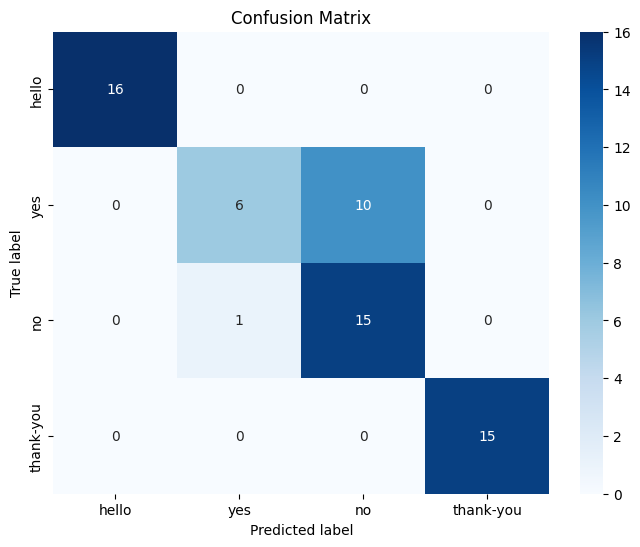

In [34]:
# --------------------- Confusion Metrix ---------------------
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=actions, yticklabels=actions)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

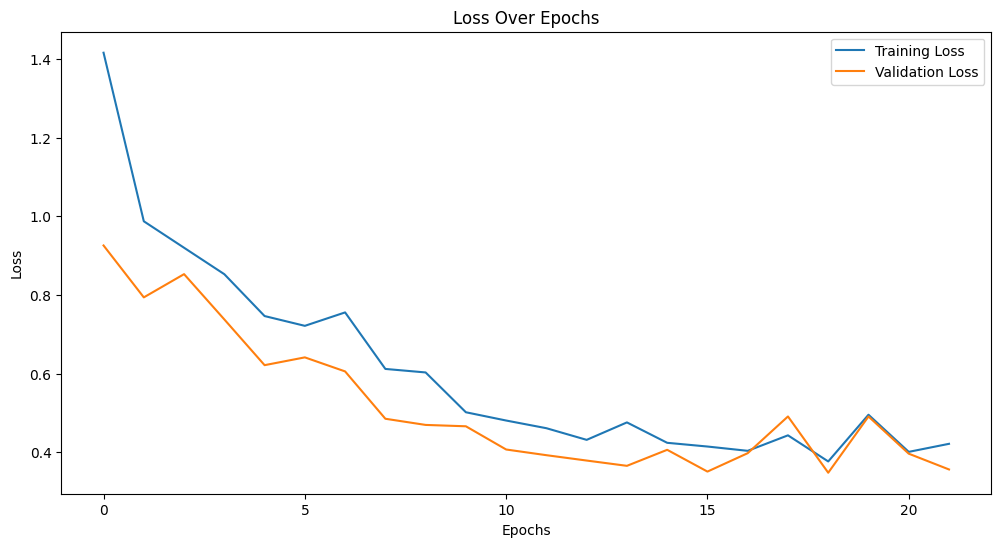

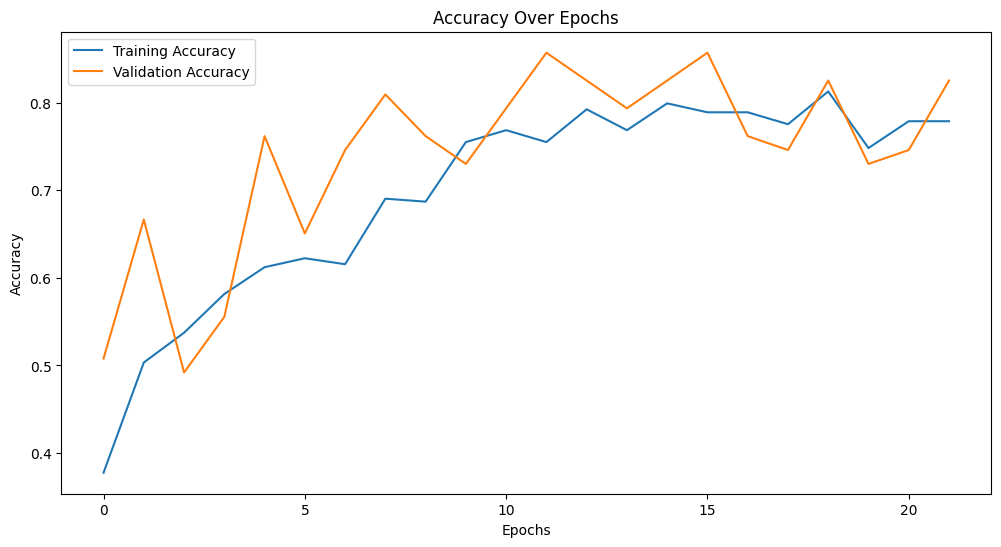

In [35]:
# --------------------- Plots ---------------------

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# --------------------- Classification Report ---------------------
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=actions))

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        16
         yes       0.86      0.38      0.52        16
          no       0.60      0.94      0.73        16
   thank-you       1.00      1.00      1.00        15

    accuracy                           0.83        63
   macro avg       0.86      0.83      0.81        63
weighted avg       0.86      0.83      0.81        63



# Section 5: Evaluation Model on a Test Set
-----------------------------------------------------------------------------------

In [39]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8211 - loss: 0.4486
Test Loss: 0.43345874547958374, Test Accuracy: 0.8253968358039856


# Section 6: Save Model
-----------------------------------------------------------------------------------

In [38]:
model.save('final-sign-language-detection-model.keras')

# Section 7: Real Time Testing
-----------------------------------------------------------------------------------

In [49]:
colors = [(255, 99, 71), (144, 238, 144), (135, 206, 250), (255, 182, 193)]  

def prob_viz(res, actions, input_frame, colors):
    """
    Visualize probabilities as filled circles for each action.

    Parameters:
        res (list): Probabilities for each action.
        actions (list): Action names.
        input_frame (ndarray): Input video frame.
        colors (list): Colors for each action.

    Returns:
        output_frame (ndarray): Frame with visualized probabilities.
    """
    output_frame = input_frame.copy()
    h, w, _ = output_frame.shape

    # Center point for circles
    start_x, start_y = 50, 80

    for num, prob in enumerate(res):
        # Calculate the radius of the filled circle based on probability
        radius = int(prob * 30)  

        # Draw a background circle
        cv2.circle(output_frame, (start_x, start_y + num * 70), 30, (200, 200, 200), -1)

        # Draw a filled circle proportional to the probability
        cv2.circle(output_frame, (start_x, start_y + num * 70), radius, colors[num], -1)

        # Add the action name next to the circle
        cv2.putText(output_frame, actions[num], (start_x + 50, start_y + num * 70 + 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame


In [53]:
sequence = []  # Stores the sequence of extracted keypoints for the current input window
sentence = []  # Maintains a list of predicted actions to display as text
threshold = 0.7  # Confidence threshold for accepting predictions

cap = cv2.VideoCapture(0)

# Set up the MediaPipe Holistic mode
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():  # Loop runs as long as the video feed is open

        # Read a frame from the video feed
        ret, frame = cap.read()

        # Perform detections using the MediaPipe model
        image, results = mediapipe_detection(frame, holistic)
        print(results)  

        # Draw landmarks on the image for visualization
        draw_styled_landmarks(image, results)

        # Extract keypoints (pose, face, hand landmarks) from the detection results
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)  # Add the extracted keypoints to the sequence
        sequence = sequence[-30:]  # Keep only the last 30 frames for model prediction

        # If the sequence is long enough for prediction (30 frames):
        if len(sequence) == 30:
            # Make a prediction using the trained model
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)]) 
            
            # Visualization logic for displaying predicted sentences
            if res[np.argmax(res)] > threshold:  # Check if the prediction confidence exceeds the threshold
                if len(sentence) > 0:  # If there is already a sentence being displayed:
                    # Append the action to the sentence if it's different from the last predicted action
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:  # Start a new sentence if there is no previous one
                    sentence.append(actions[np.argmax(res)])

            # Keep the sentence length to a maximum of 5 words
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Generate visualization of prediction probabilities on the image
            image = prob_viz(res, actions, image, colors)
        
        # Draw a rectangle at the top of the image for displaying the sentence
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Display the annotated image with OpenCV
        cv2.imshow('OpenCV Feed', image)

        # Check if the user presses 'q' to exit the loop gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Release the video capture and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti